<a href="https://colab.research.google.com/github/ykato27/GAN/blob/main/JAX_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## JAXとは
- Google製のライブラリで、AutogradとXLAからなる、機械学習のための数値計算ライブラリ

#### Data generation

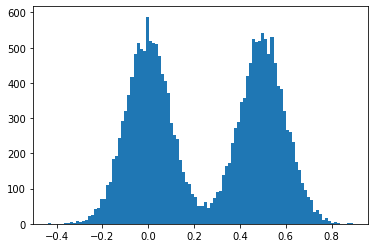

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.data import Dataset

data = np.concatenate([np.random.normal(0, 0.1, 10000), np.random.normal(0.5, 0.1, 10000)])
plt.hist(data, 100);

train_set = Dataset.from_tensor_slices(data).shuffle(len(data), reshuffle_each_iteration=True).batch(10).prefetch(1)

#### Training 1-d GAN (PyTorch)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


epoch: 0, g_loss: 0.40, d_loss: 0.27, elapased: 14.29
epoch: 1, g_loss: 0.34, d_loss: 0.24, elapased: 13.80
epoch: 2, g_loss: 0.26, d_loss: 0.23, elapased: 13.93
epoch: 3, g_loss: 0.28, d_loss: 0.23, elapased: 13.93
epoch: 4, g_loss: 0.28, d_loss: 0.24, elapased: 13.81
epoch: 5, g_loss: 0.27, d_loss: 0.24, elapased: 13.88
epoch: 6, g_loss: 0.26, d_loss: 0.25, elapased: 13.86
epoch: 7, g_loss: 0.26, d_loss: 0.25, elapased: 13.86
epoch: 8, g_loss: 0.26, d_loss: 0.25, elapased: 13.98
epoch: 9, g_loss: 0.26, d_loss: 0.25, elapased: 13.95
epoch: 10, g_loss: 0.26, d_loss: 0.25, elapased: 13.92
epoch: 11, g_loss: 0.25, d_loss: 0.25, elapased: 13.90
epoch: 12, g_loss: 0.26, d_loss: 0.25, elapased: 13.72
epoch: 13, g_loss: 0.25, d_loss: 0.25, elapased: 13.83
epoch: 14, g_loss: 0.25, d_loss: 0.25, elapased: 13.74
epoch: 15, g_loss: 0.26, d_loss: 0.25, elapased: 13.76
epoch: 16, g_loss: 0.25, d_loss: 0.25, elapased: 13.53
epoch: 17, g_loss: 0.25, d_loss: 0.25, elapased: 13.54
epoch: 18, g_loss: 0

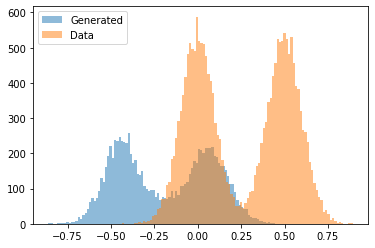

total elapsed:  419.60


In [2]:
import time

import torch
import torch.nn as nn
import torch.optim as optim


class Generator(nn.Module):
    def __init__(self, z_dim=512):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(z_dim, 64), nn.BatchNorm1d(64, 0.8), nn.ReLU(),
                                 nn.Linear(64, 32), nn.BatchNorm1d(32, 0.8), nn.ReLU(),
                                 nn.Linear(32, 1))
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(1, 32), nn.BatchNorm1d(32, 0.8), nn.ReLU(),
                                 nn.Linear(32, 64), nn.BatchNorm1d(64, 0.8), nn.ReLU(),
                                 nn.Linear(64, 1))
        
        
    def forward(self, x):
        return self.net(x)

z_dim = 512
generator = Generator(z_dim)
g_opt = optim.Adam(generator.parameters(), lr=0.00005)
discriminator = Discriminator()
d_opt = optim.Adam(discriminator.parameters(), lr=0.0001)
criterion = nn.MSELoss()

def g_step(z):
    valid = torch.ones((len(z), 1))
    fake_data = generator(z)
    g_loss = criterion(discriminator(fake_data), valid)
    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    return g_loss, fake_data

def d_step(real_data, fake_data):
    valid = torch.ones((len(real_data), 1))
    fake = torch.zeros((len(fake_data), 1))
    d_loss_real = criterion(discriminator(real_data), valid)
    d_opt.zero_grad()
    d_loss_real.backward()
    d_opt.step()
    d_loss_fake = criterion(discriminator(fake_data.detach()), fake)
    d_opt.zero_grad()
    d_loss_fake.backward()
    d_opt.step()
    d_loss = (d_loss_real + d_loss_fake) / 2.

    return d_loss

elapsed_total = 0.0
for e in range(30):
    g_loss_avg, d_loss_avg = 0, 0
    tic = time.time()
    for x in train_set.as_numpy_iterator():
        n = len(x)
        real_data = torch.from_numpy(x).float().reshape(n, -1)
        z = torch.randn((n, z_dim))
        g_loss, fake_data = g_step(z)
        d_loss = d_step(real_data, fake_data)
        g_loss_avg += g_loss.item()
        d_loss_avg += d_loss.item()
    g_loss_avg /= len(train_set)
    d_loss_avg /= len(train_set)
    elapsed = time.time() - tic
    elapsed_total += elapsed
    print(f"epoch: {e}, g_loss: {g_loss_avg:0.2f}, d_loss: {d_loss_avg:0.2f}, elapased: {elapsed:0.2f}")

z = torch.randn((10000, z_dim))
fake_data = generator(z).detach().flatten().numpy()
plt.figure()
plt.hist(fake_data, 100, alpha=.5);
plt.hist(data, 100, alpha=.5);
plt.legend(["Generated", "Data"])
plt.show()
print(f"total elapsed: {elapsed_total: 0.2f}")

In [3]:
!pip install --quiet flax

     |████████████████████████████████| 193 kB 5.3 MB/s 
     |████████████████████████████████| 118 kB 43.4 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 


epoch: 0, g_loss: 0.31, d_loss: 0.21, elapased: 13.37
epoch: 1, g_loss: 0.36, d_loss: 0.17, elapased: 6.89
epoch: 2, g_loss: 0.41, d_loss: 0.15, elapased: 7.03
epoch: 3, g_loss: 0.42, d_loss: 0.15, elapased: 6.93
epoch: 4, g_loss: 0.40, d_loss: 0.15, elapased: 6.86
epoch: 5, g_loss: 0.43, d_loss: 0.14, elapased: 6.97
epoch: 6, g_loss: 0.46, d_loss: 0.13, elapased: 6.98
epoch: 7, g_loss: 0.49, d_loss: 0.12, elapased: 6.99
epoch: 8, g_loss: 0.52, d_loss: 0.11, elapased: 6.87
epoch: 9, g_loss: 0.56, d_loss: 0.10, elapased: 6.89
epoch: 10, g_loss: 0.60, d_loss: 0.09, elapased: 6.88
epoch: 11, g_loss: 0.63, d_loss: 0.09, elapased: 6.92
epoch: 12, g_loss: 0.65, d_loss: 0.09, elapased: 6.79
epoch: 13, g_loss: 0.66, d_loss: 0.09, elapased: 6.79
epoch: 14, g_loss: 0.65, d_loss: 0.09, elapased: 6.97
epoch: 15, g_loss: 0.65, d_loss: 0.10, elapased: 6.80
epoch: 16, g_loss: 0.62, d_loss: 0.10, elapased: 6.98
epoch: 17, g_loss: 0.60, d_loss: 0.11, elapased: 6.96
epoch: 18, g_loss: 0.54, d_loss: 0.13

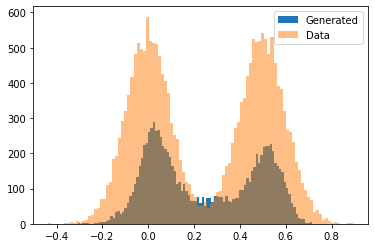

total elapsed:  212.83


In [4]:
from functools import partial

import jax
import jax.numpy as jnp
import flax.linen as fnn
from flax.core import FrozenDict
from flax.training.train_state import TrainState
import optax


class Generator(fnn.Module):
    @fnn.compact
    def __call__(self, z, use_running_average):
        h = fnn.Dense(64)(z)
        h = fnn.BatchNorm(use_running_average=use_running_average, momentum=0.8)(h)
        h = fnn.relu(h)
        h = fnn.Dense(32)(h)
        h = fnn.BatchNorm(use_running_average=use_running_average, momentum=0.8)(h)
        h = fnn.relu(h)
        y = fnn.Dense(1)(h)
        return y

class Discriminator(fnn.Module):
    @fnn.compact
    def __call__(self, x, use_running_average):
        h = fnn.Dense(32)(x)
        h = fnn.BatchNorm(use_running_average=use_running_average, momentum=0.8)(h)
        h = fnn.relu(h)
        h = fnn.Dense(64)(h)
        h = fnn.BatchNorm(use_running_average=use_running_average, momentum=0.8)(h)
        h = fnn.relu(h)
        y = fnn.Dense(1)(h)
        return y

class CustomTrainState(TrainState):
    batch_stats: dict
    
    def apply_fn_with_bn(self, *args, is_training, **nargs):
        output, mutated_vars = self.apply_fn(*args, **nargs, use_running_average=not is_training, mutable=["batch_stats"])
        new_batch_stats = mutated_vars["batch_stats"]
        return output, new_batch_stats
    
    def update_batch_stats(self, new_batch_stats):
        return self.replace(batch_stats=new_batch_stats)
    
@partial(jax.jit, static_argnums=(3,))
def g_step(z, g_state, d_state, is_training=True):
    def loss_fn(g_params, g_bs, d_params, d_bs, is_training):
        gen_data, g_bs = g_state.apply_fn_with_bn({"params": g_params, "batch_stats": g_bs}, z, is_training=is_training)
        validity, d_bs = d_state.apply_fn_with_bn({"params": d_params, "batch_stats": d_bs}, gen_data, is_training=is_training)
        g_loss = optax.l2_loss(validity, jnp.ones((len(validity), 1))).mean() * 2.
        # multiplication by 2 to make the loss consistent with pytorch. see https://github.com/deepmind/optax/blob/master/optax/_src/loss.py#L32#L54
        return g_loss, (gen_data, g_bs, d_bs)
        
    if is_training:
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (g_loss, (gen_data, g_bs, d_bs)), grads = grad_fn(g_state.params, g_state.batch_stats, d_state.params, d_state.batch_stats, True)
        g_state = g_state.apply_gradients(grads=grads)
        g_state = g_state.update_batch_stats(g_bs)
        d_state = g_state.update_batch_stats(d_bs)
    else:
        g_loss, (gen_data, g_bs, d_bs) = loss_fn(g_state.params, g_state.batch_stats, d_state.params, d_state.batch_stats, False)
    
    return g_loss, g_state, gen_data

@partial(jax.jit, static_argnums=(3,))
def d_step(real_data, fake_data, d_state, is_training=True):
    valid = jnp.ones((len(real_data), 1))
    fake = jnp.zeros((len(fake_data), 1))
    def loss_fn(d_params, d_bs, is_training):
        validity, d_bs = d_state.apply_fn_with_bn({"params": d_params, "batch_stats": d_bs}, x, is_training=is_training)
        d_loss = optax.l2_loss(validity, y).mean()
        return d_loss, d_bs
    
    loss = 0.
    if is_training:
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        for x, y in zip([real_data, fake_data], [valid, fake]):
            (loss_, d_bs), grads = grad_fn(d_state.params, d_state.batch_stats, True)
            d_state = d_state.apply_gradients(grads=grads)
            d_state = d_state.update_batch_stats(d_bs)
            loss += loss_
    else:
        for x, y in zip([real_data, fake_data], [valid, fake]):
            loss_, d_bs = loss_fn(d_state.params, d_state.batch_stats, False)
            loss += loss_
        
    return loss, d_state
    
key = jax.random.PRNGKey(0)

z_dim = 512
g = Generator()
subkey, key = jax.random.split(key)
g_variables = g.init(subkey, jnp.ones((1, z_dim)), True)
g_tx = optax.adam(0.00005)
g_state = CustomTrainState.create(apply_fn=g.apply, params=g_variables["params"], tx=g_tx, batch_stats=g_variables["batch_stats"])

d = Discriminator()
subkey, key = jax.random.split(key)
d_variables = d.init(subkey, jnp.ones((1, 1)), True)
d_tx = optax.adam(0.0001)
d_state = CustomTrainState.create(apply_fn=d.apply, params=d_variables["params"], tx=d_tx, batch_stats=d_variables["batch_stats"])

elapsed_total = 0.0
for e in range(30):
    g_loss_avg, d_loss_avg = 0, 0
    tic = time.time()
    for x in train_set.as_numpy_iterator():
        subkey, key = jax.random.split(key)
        z = jax.random.normal(subkey, (32, z_dim))
        real_data = jnp.array(x).reshape(-1, 1)
        g_loss, g_state, gen_data = g_step(z, g_state, d_state, True)
        d_loss, d_state = d_step(real_data, gen_data, d_state, True)
        g_loss_avg += g_loss
        d_loss_avg += d_loss
    g_loss_avg /= len(train_set)
    d_loss_avg /= len(train_set)
    elapsed = time.time() - tic
    elapsed_total += elapsed
    print(f"epoch: {e}, g_loss: {g_loss_avg:0.2f}, d_loss: {d_loss_avg:0.2f}, elapased: {elapsed:0.2f}")
z = jax.random.normal(key, (10000, z_dim))
gen_data, g_bs = g_state.apply_fn_with_bn({"params": g_state.params, "batch_stats": g_state.batch_stats}, z, is_training=False)
plt.hist(gen_data.flatten(), 100);
plt.hist(data, 100, alpha=.5);
plt.legend(["Generated", "Data"])
plt.show()

print(f"total elapsed: {elapsed_total: 0.2f}")